# Kryptografia krzywych eliptycznych
Autorka: Julia Zduńczyk


W ostatnich latach kryptografia krzywych eliptycznych staje się coraz  bardziej popularnym pojęciem. Gdy podejrzymy  sobie w przeglądarce certyfikaty dla tak popularnych domen jak np. facebook.com czy google.com, zobaczymy, że używają one krzywych eliptycznych.

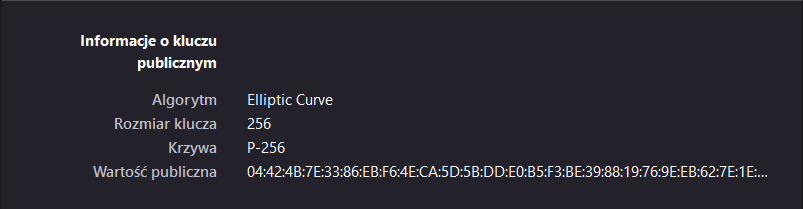

Co to jednak dokładnie oznacza i w jaki sposób jest powiązane z kluczem publicznym? Dlaczego klucz jest tak krótki, w porównaniu do kluczy używanych w przypadku algorytmu RSA?

By to zrozumieć, należy zacząc od tego, czym tak naprawdę są krzywe eliptyczne.

Krzywa eliptyczna to krzywa zdefiniowana jako:
$$y^2 = x^3 + ax + b$$
Widzimy zatem, że kształt krzywej będzie zależny od wyboru współczynników a i b.
Zobaczmy, jak będzie wyglądać krzywa o współczynnikach: $$a=-3$$ $$b=5$$



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def draw_elliptic_curve(a, b):
    y, x = np.ogrid[-4:4:100j, -4:4:100j]
    X_grid, Y_grid = np.meshgrid(x,y)
    plt.contour(X_grid, Y_grid, pow(y, 2) - pow(x, 3) - x * a - b, [0])
    plt.axhline(y=0, color='r')
    plt.axvline(x=0, color='b')


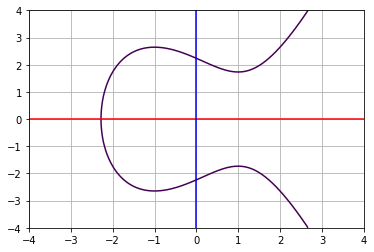

In [ ]:
draw_elliptic_curve(-3, 5) #wypróbuj także inne wartości
plt.grid()
plt.show()


Zauważmy, że krzywa jest symetryczna względem osi X. To będzie miało duże znaczenie dla definicji operacji na krzywej.


## Dodawanie punktów na krzywej

Załóżmy, że mamy punkt A i punkt B (A != B) na krzywej. Dodawanie definiujemy w taki sposób: prowadzimy prostą, przechodzącą przez obydwa punkty. Trzecie miejsce, w którym prosta przetnie krzywą, nazwiemy punktem C. Wynikiem dodawania A+B jest punkt -C, czyli punkt C odbity względem osi X. 

Punkt o współrzędnej y==0 (na krzywej istnieje taki jeden) stanowić będzie element neutralny dodawania. 

Dodając do niego punkt P w wyniku otrzymamy punkt P. 

Dodając punkt A = (x, y) do punktu B = (x, -y) otrzymamy punkt O = (x, 0)

Napiszmy kod, który to zobrazuje:

In [ ]:
#Zacznijmy od stworzenia punktu:
class Point(object):
    def __init__(self, curve, x, y):
        self.curve = curve #krzywa, na ktorej ma znajdować się ten punkt
        self.x = x
        self.y = y

        # if not curve.testPoint(x,y): #sprawdzam, czy punkt jest na krzywej
        #   raise Exception("The point %s is not on the given curve %s" % (self, curve))

    def __str__(self):
        return "Point({}, {})".format(self.x, self.y)

    def opposite(self):
        return Point(self.curve, self.x, -self.y)

    #teraz zdefiniujemy dodawania punktow na krzywej
    def __add__(self, other):
        # print(other)
        # assert type(other) is (Point or Ideal)
        
        if isinstance(other, Ideal): #jeśli dodajemy punkt P do punktu o y=0, to z definicji otrzymujemy punkt P
          return self
 
        if self.x == other.x and self.y == other.y:
            if self.y == 0:
              return Ideal(self.curve)
            return self.double()

        if self.x == other.x:  #jeśli dodajemy punktu o tych samych współrzędnych x, ale innych y, to otrzymujemy "idealny" punkt, czyli ten o y=0
            return Ideal(self.curve)

        dx = other.x - self.x
        dy = other.y - self.y
        if dx == 0:
            return Point()
        slope = dy / dx
        x = (slope ** 2) - self.x - other.x
        y = slope * x + (self.y - slope * self.x)
        return Point(self.curve, x, -y)

    # prosta funkcja na podwojenie punktu
    def double(self):
        slope = (3 * (self.x ** 2) + self.curve.a) / (2 * self.y)
        x = (slope ** 2) - (2 * self.x)
        y = slope * x + (self.y - slope * self.x)
        return Point(self.curve, x, -y)

    #
    def __mul__(self, n):
        if not isinstance(n, int):
            raise Exception("Can't scale a point by something which isn't an int!")
        else:
            if n == 0:
                return Ideal(self.curve)
            else:
                Q = self
                if n & 1 == 1: # operacja na bitach - sprawdzamy, czy ostatnia cyfra n w postaci binarnej to 1 (czyli czy jest nieparzysta)
                    R = self
                else:
                    R = Ideal(self.curve) # jesli parzyste to R będzie elementem neutralnym 

                i = 2 # ustawiamy i jako potege dwójki
                while i <= n:
                    Q = Q + Q

                    if n & i == i: #sprawdzam czy bit na i pozycji jest takze równy 1 w bitowej formie n
                        R = Q + R

                    i = i << 1 #zwiekszamy i do kolejnej potegi dwójki
        return R
 
    def __rmul__(self, n):  #to na wypadek gdy jako pierwszy podamy int, np 20*P zamiast P*20
      return self * n

    def np(self):
        return np.array([self.x, self.y])


#teraz stworzymy specjalną podklasę dla wyjątkowego punktu krzywej - punktu o współrzędnej y==0
class Ideal(Point):  
    def __init__(self, curve):
        self.curve = curve
  
    def __str__(self):
        return "Neutral"
      
    def opposite(self):
        return self

    def __add__(self, Q):
        return Q
    
    def __mul__(self, n):
        if not isinstance(n, int):
            raise Exception("Can't scale a point by something which isn't an int!")
        else:
            return self

#teraz zdefiniujmy krzywą
class EllipticCurve(object):
    def __init__(self, a, b):
        self.a = a
        self.b = b

        self.discriminant = -16 * (4 * pow(a, 3) + 27 * pow(b, 2)) #upewnimy się, że jest dobra
        if not self.isSmooth():
            raise Exception("The curve %s is not smooth!" % self)

    def isSmooth(self):
        return self.discriminant != 0

    def testPoint(self, x, y):  #testowanie czy punkt do niej należy
        return y*y == pow(x, 3) + self.a * x + self.b

    def __str__(self):
        return 'y^2 = x^3 + %Gx + %G' % (self.a, self.b)

    def __eq__(self, other):
        return (self.a, self.b) == (other.a, other.b)

    def y_value(self, x):
        """Get positive y value of the curve given x"""
        return pow(pow(x, 3) + x * self.a + self.b, 0.5)

  

Sprawdzenie dla kilku testowych danych:

In [ ]:
C = EllipticCurve(a=-2,b=4)
P = Point(C, 3, 5)
Q = Point(C, -2, 0)
print(P+Q)
print(Q+P)
print(Q+Q)
print(P+P)


Point(0.0, -2.0)
Point(0.0, -2.0)
Neutral
Point(0.25, 1.875)


Teraz zobrazujmy to za pomocą biblioteki matplotlib:

In [ ]:
def plot_distinct_point_curve(p0, p1, p0_annotation, p1_annotation, third_point_annotation, sum_point_annotation): #Dodając punkty będziemy podawać, w jaki sposó chcemy je podpisać na wykresie
    draw_elliptic_curve(p0.curve.a, p0.curve.b) #funkcja do rysowania krzywych eliptycznych zapisana już wyżej
    
    p2 = p0 + p1

    line0 = np.array([
        p0.np(),  # p0.x, p0.y
        p2.opposite().np(), #p2.x, p2.-y
        p1.np() # p1.x, p1.y
    ])
    plt.plot(line0[:,0], line0[:,1], marker='o')
    plt.annotate(p0_annotation, xy=line0[0], xytext=(-5, 5), textcoords='offset points')
    plt.annotate(p1_annotation, xy=line0[2], xytext=(-5, 5), textcoords='offset points')
    plt.annotate(third_point_annotation, xy=line0[1], xytext=(-5, 5), textcoords='offset points')

    line1 = np.array([
        p2.opposite().np(),
        p2.np()
    ])
    plt.plot(line1[:,0], line1[:,1], marker='o')
    plt.annotate(sum_point_annotation, xy=line1[1], xytext=(0, 5), textcoords='offset points')

    plt.grid()
    plt.show()
    

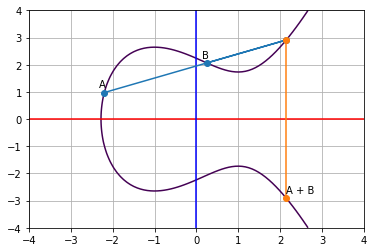

In [ ]:
C = EllipticCurve(a = -3, b = 5)
x1 = -2.2 #możesz pozmieniać te wartości, by zaobserwować dodawanie dla innych przypadków
x2 = 0.25
a = Point(C, x1, C.y_value(x1))
b = Point(C, x2, C.y_value(x2))
plot_distinct_point_curve(
    a, b,
    'A', 'B', '', 'A + B'
)

Jak widać na grafice, wybraliśmy dwa punkty or óżnych współrzędnych x, i dodaliśmy je do siebie prowadząc orzez nie prostą i odbijając punkt przecięcia tej prostej z krzywą względem osi x. Spróbujmy teraz dodać do uzyskanego A + B inny punkt C

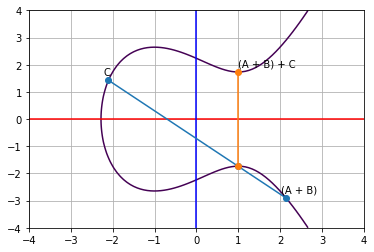

In [ ]:
ab = a + b
x3 = -2.1
c = Point(C, x3, C.y_value(x3))

plot_distinct_point_curve(
    ab, c,
    '(A + B)', 'C', '', '(A + B) + C'
)



Możemy w ten sposób "skakać" po krzywej tak długo, aż nie spróbujemy dodać dwóch punktów o tych samych wspórzędnych x (co zwróci nam punkt neutralny) 

### Dodawanie do siebie tego samego punktu
Kolejną ważną operacją będzie dodawanie do siebie tego samego punktu. W tym wypadku, zamiast prowadzić prostą przez dwa punkty, wyznaczymy prostą styczną do wybranego punktu P. Miejsce przecięcia tej prostej z krzywą wyznaczy punkt -2P, a po odbiciu względem osi X otrzymamy 2P.


In [ ]:
def plot_double_point_curve(p, p_annotation, sum_point_annotation):
    draw_elliptic_curve(p.curve.a, p.curve.b)
    
    p2 = p.double()

    line0 = np.array([
        p.np(),
        p2.opposite().np(),
    ])
    plt.plot(line0[:,0], line0[:,1], marker='o')
    plt.annotate(p_annotation, xy=line0[0], xytext=(-5, 5), textcoords='offset points')

    line1 = np.array([
        p2.opposite().np(),
        p2.np()
    ])
    plt.plot(line1[:,0], line1[:,1], marker='o')
    plt.annotate(sum_point_annotation, xy=line1[1], xytext=(0, 5), textcoords='offset points')

    plt.grid()
    plt.show()
    

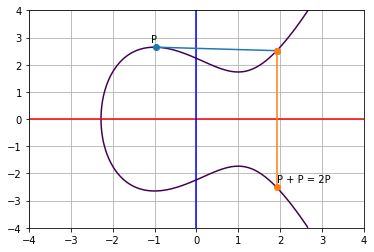

In [ ]:
C = EllipticCurve(a = -3, b = 5)
x = -0.96
p = Point(C, x, C.y_value(x))
plot_double_point_curve(p, "P", "P + P = 2P")



Teraz możemy poprzednio poznanym sposobem dodać punkt P do punktu 2P, by otrzymać 3P:

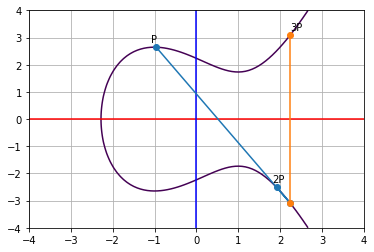

In [ ]:
p2 = p.double()
plot_distinct_point_curve(
    p, p2,
    'P', '2P', '', '3P'
)

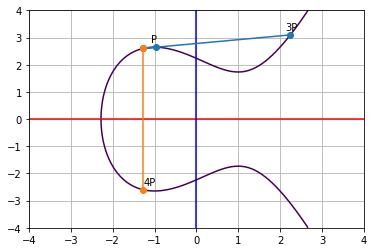

In [ ]:
p3 = p + p2
plot_distinct_point_curve(
    p, p3,
    'P', '3P', '', '4P'
)

Powyższe operacje możemy wykonywać wiele razy, tak by otrzymać NP. Jednak, jak odkryć, ile wynosi N, jeśli mamy jedynie koordynaty P i NP? Spójrzmy na poniższy wykres:

In [ ]:
def plot_n_point_curve(p, n, p_annotation, sum_point_annotation):
    draw_elliptic_curve(p.curve.a, p.curve.b)
    
    current_p = p
    for _ in range(n):
        current_p += p

    line0 = np.array([
        p.np(),
        current_p.np(),
    ])
    plt.plot(line0[:,0], line0[:,1], linestyle='--', marker='o')
    plt.annotate(p_annotation, xy=line0[0], xytext=(-5, 5), textcoords='offset points')
    plt.annotate(sum_point_annotation, xy=line0[1], xytext=(-5, 5), textcoords='offset points')

    plt.grid()
    plt.show()

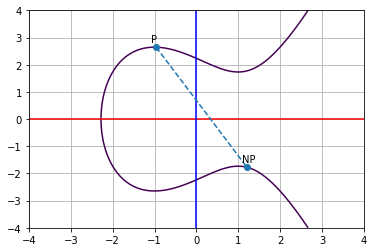

In [ ]:
plot_n_point_curve(
    p, 16,
    'P', 'NP'
)

Patrząc na wykres, bardzo trudno jest zgadnąć, ile razy zostało dodane do siebie P - należało by po kolei sprawdzać każą wartość (P, 2P, 3P itd), tak by odkryć właściwą, ponieważ nie ma żadnego sposobu na stwierdzenie przybliżonej wartości n. Nawet wartości zbliżone do siebie mogą dać całkiem odległe punkty. Sprawdźmy to na poniższym przykładzie dla n = 10 i n = 11:

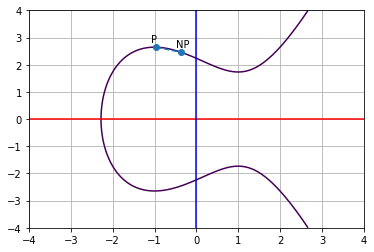

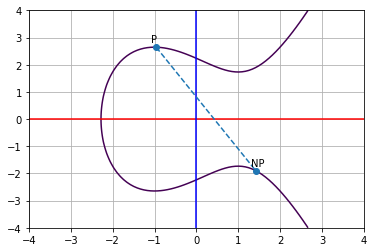

In [ ]:
plot_n_point_curve(
    p, 10,
    'P', 'NP'
)
plot_n_point_curve(
    p, 11,
    'P', 'NP'
)

W powyższym przykładzie odnalezienie N dla pierwszego wykresu nie będzie jeszcze tak trudne, jako że stanowiło ono 16. Co jednak, gdy N będzie wielkością rzędu 2^256?

Dodawanie do siebie punktu P miliony razy jest bardzo czasochłonną operacją, niewykonalną w sensownym czasie. To właśnie problem dodawania punktu do siebie ogromną ilość razy stanowi podstawę krytografii krzywych eliptycznych, tak samo jak problem faktoryzacji liczb całkowitych stanowi podstawę algorytmu RSA. 

W przypadku kryptografii krzywych eliptycznych NP stanowić klucz publiczny, N klucz prywatny, a P będzie powszechnie znaną wartością. 

### Mnożenie punktu przez n


Wiemy już, że dodawanie do siebie punktu P stanowi czasochłonną operację, na czym opiera się bezpieczeństwo kryptografii krzywych eliptycznych. Jak jednak uzyskać punkt NP, znając N? Nie chcemy przecież, by było to niemożliwe do obliczenia w realnym czasie także dla właściciela klucza prywatnego, inaczej system kryptografuczny nie miałby sensu.

Odpowiedzią na to będzie metoda "podwajaj i dodawaj" ("double-and-add")

Zauważmy, że aby uzyskać 4P, możemy oczywiście wykonać po kolei operacje P + P + P + P:

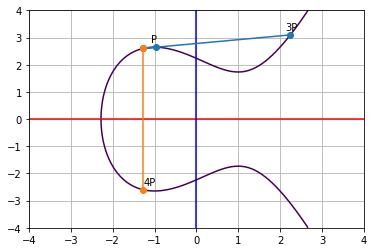

In [ ]:
p3 = p + p2
plot_distinct_point_curve(
    p, p3,
    'P', '3P', '', '4P'
)

Możemy jednak zmniejszyć ilość operacji:
$$P + P = 2P$$
$$4P = 2P + 2P.$$

Zobaczmy, że tą metodą otrzymamy taki sam wynik:

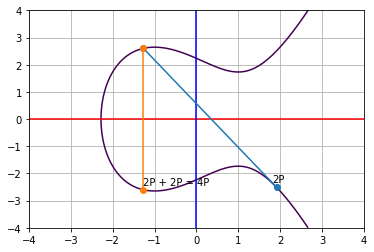

In [ ]:
p2 = p + p
plot_double_point_curve(p2, "2P", "2P + 2P = 4P")

Zatem znając N, możemy łatwo wielokrotnie przyspieszyć proces dodawania - wystarczy, że zapiszemy liczbę n w postaci binarnej. 

Załóżmy, że chcemy otrzymać punkt 123P.

Liczba 123 zapisana w postaci binarnej to $$1111011$$

Możemy więc zapisać 123P jako $$64P + 32P + 16P + 8P + 2P + P$$
Wykonalibyśmy więc takie operacje:


*   Dodaj P i podwój P
*   Dodaj 2P i podwój 2P
*   Podwój 4P
*   Dodaj 8P i podwój 8P
*   Dodaj 16P i podwój 16P
*   Dodaj 32P i podwój 32P
*   Dodaj 64P i podwój 64P

(Ostatnie podwojenie jest w teorii niepotrzebne, ale z definicji algorytmu dodajemy i podwajamy dla każdego bitu równego 1)

W efekcie zamiast wykonać 127 trudnych obliczeniowo "skoków" po krzywej, wykonaliśmy 7. 

Dla większych liczb ta różnica staje się jeszcze bardziej znacząca - dla liczby rzędu $2^{275}$ wykonamy tylko 275 kroków, zamiast około $10^{82}$.








# Krzywa eliptyczna Diffiego-Hellmana

Zobaczmy teraz, jak będzie działał protokół wymiany klucza oparty na krzywych eliptycznych. 

Załózmy, że Alicja chce skontaktować się z Bobem, obawiają się jednak, że ktoś podsłuchuje ich rozmowy. Muszę więc ustalić sekretny klucz, tak by obydwoje go znali, ale jednocześnie żeby w żadnym momencie nie był on bezpośrednio przesyłany między nimi, tak by nie mógł zostać przechwycony.

W pierwszym kroku Alicja wraz z Bobem wspólnie ustanawiają punkt startowy P - nie jest on sekretny, zatem bez problemu może zostać przesłany kanałem komunikacji. Następnie Alicja wysyła Bobowi swój klucz publiczny nP, a Bob wysyła alicji swój klucz publiczny mP.

W następnym kroku Alicja oblicza n(mB), a Bob oblicza m(nB) - w efekcie uzyskują ten sam klucz nmP = mnP

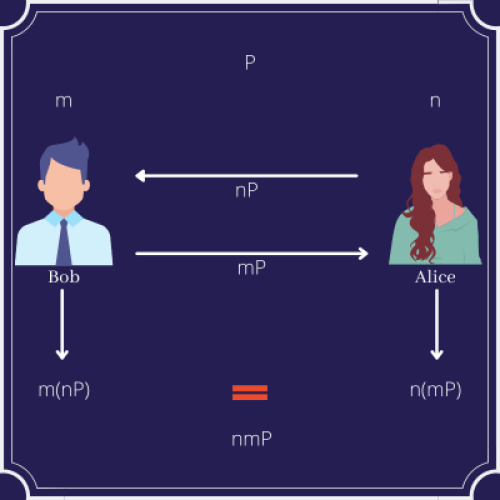

Sprawdźmy to jeszcze za pomocą kodu:

In [ ]:
x = -0.96
p = Point(C, x, C.y_value(x))
p6 = 6*p
p4 = 4*p
print(p6)
print(p4)
p_6_4 = (p6*4)
p_4_6 = (p4*6)
print(p_6_4)
print(p_4_6)

Point(-0.6554654356003782, 2.585495205080919)
Point(-1.2657994249117057, -2.6017827435677456)
Point(-2.1944677569467164, -1.007734891519071)
Point(-2.1944677569467155, -1.0077348915190787)


Wynik jest niemal identyczny - różnica występuje jedynie w dalszych cyfrach po przecinku. Jest to związne z zaokrągleniami stosowanymi przez program przy liczeniu części ułamkowej. W rzeczywistości jest to olbrzymi problem, który uniemożliwia stosowanie kryptografii krzywych eliptycznych w tej formie, ponieważ nie możemy działać na przybliżeniach - powyższe wyniki powinny byź jednoznacznie takie same. 

# Problem zaokrąglenia

W rzeczywistości kryptografia krzywych eliptycznych wygląda nieco inaczej - by rozwiązać problem zaokrągleń nie działamy na liczbach rzeczywsitych, jak w powyższych przykładach, a nad ciałem skończonym liczb całkowitych modulo p, gdzie p jest liczbą pierwszą. 

Teraz równanie krzywej będzie wyglądać w ten sposób:

$$y^2 = x^3 + ax + b  (mod p)$$



Zobaczmy teraz, jak będzie wyglądała krzywa nad ciałem liczb całkowitych:

In [ ]:
class F_EllipticCurve(object):
    def __init__(self, p, a, b):
        self.p = p
        self.a = a
        self.b = b
        self.points = []
        self.find_points()

    def find_points(self):
      for x in range(self.p):
          for y in range(self.p):
              if (y ** 2) % self.p == ((x ** 3) + self.a * x + self.b) % self.p:
                  self.points.append((x, y))

    def testPoint(self, x, y):  #testowanie czy punkt do niej należy
        return y*y % self.p == pow(x, 3) + self.a * x + self.b % self.p

    def __str__(self):
        return 'y^2 = x^3 + %Gx + %G mod %G' % (self.a, self.b, self.p)

    def __eq__(self, other):
        return (self.p, self.a, self.b) == (other.p, other.a, other.b)

In [ ]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 90
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator

def plot_curve(curve, ax, point_sizes, point_colors):
    points = curve.points
    points = np.array(points)

    ax.scatter(
        points[:,0],
        points[:,1],
        list(map(lambda p: point_sizes.get(tuple(p), 10), points)),
        list(map(lambda p: point_colors.get(tuple(p), 'purple'), points)),
        zorder=5,
    )
    ax.set_axisbelow(True)
    ax.grid()
    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.axhline(y=9.5, color='grey', linestyle='--')
    
    ax.set_ylim(top=curve.p)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    ax.set_xlim(right=curve.p)

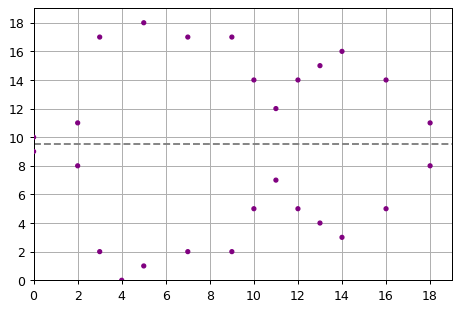

In [ ]:
fig, ax = plt.subplots()
curve = F_EllipticCurve(19, -3, 5)
plot_curve(curve, ax, {}, {})



Na pierwszy rzut oka nie przypomina to już "krzywej", jednak tak właśnie wygląda ona nad ciałem liczb całkowitych. Zauważmy, że jej własności się zgadzają - wciąż jest symetryczna, tym razem nie jednak względem osi X, jako że modulo p wszystkie wartości będą liczbami dodatnimi - jest ona symetrzyczna względem prostej y = p/2. 

W przypadku krzywej nad ciałem liczb całkowitych, by uzyskać punkty, będziemy po prostu sprawdzać, dla jakich wartości $y^2 (mod p)$ będzie równe $x^3 + ax + b (modp)$

Weźmy na przykład punkt $(2, 8)$ z powyższego przykładu:
$$y^2 = 8^2 = 64 = 7 mod 19$$
$$x^3 + ax + b = 8 - 6 + 5 = 7 = 7 mod 19$$
Na podstawie obliczeń widzimy więc, że punkt należy do krzywej.

Dodawanie punktów na krzywej również będzie działać na podobnej zasadzie, co wcześniej, z jedną różnicą - tym razem wyobraźmy sobie, że połączyliśmy ze sobą górną z dolną oraz prawą z lewą krawędzią powyższego wykresu, otrzymując torus:


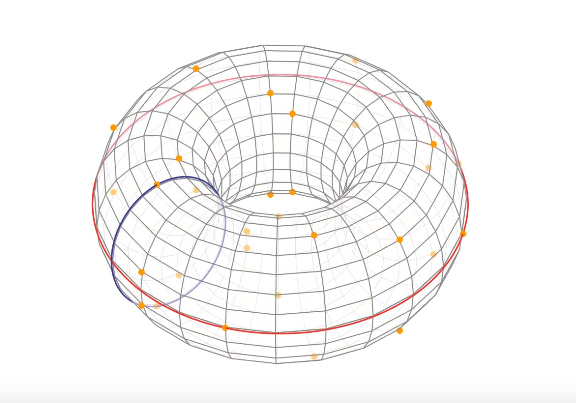

Teraz przeprowadzimy prostą przez dwa punkty, które zamierzamy do siebie dodać. Prostą będziemy przedłużać tak długo, "zawijając" ją wokół torusa, aż trafi na jakiś punkt:

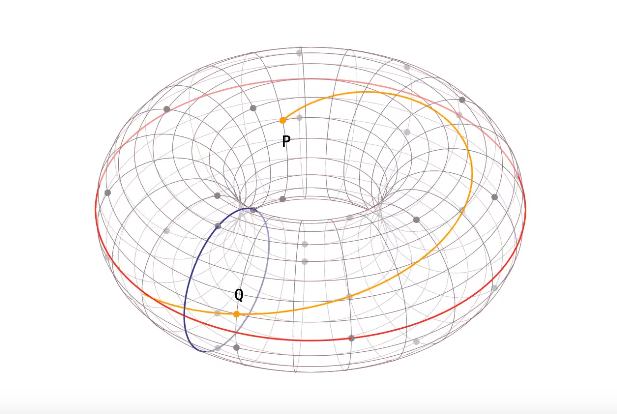

Następnie punkt ten odbijemy względem osi symetrii krzywej.

W analogiczny sposób będzie działać dodawanie punktu do samego siebie.

# Podsumowanie

### Zalety

Wielką zaletą kryptografii krzywych eliptycznych jest możliwość stosowania stosunkowo krótkiego klucza. Obecnie uważane za bezpieczne są klucze długości 256 bitów, podczas gdy w algorytmie RSA należałoby użyć klucza długości 3072 by uzyskać taki sam poziom bezpieczeństwa. Poniżej więcej porównań (według zaleceń NIST):

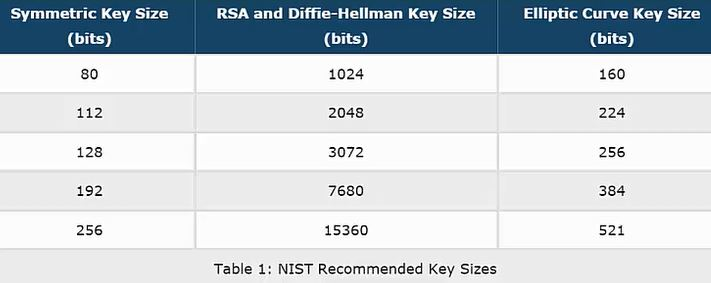

Dzięki tej różnicy używanie kryptografii krzywych eliptycznych wydaje się korzystne dla urządzeń z mniejszą mocą obliczeniową. Krótsze klucze mogą także powodować przyspieszenie procesu SSL handshake, co pozytywnie wpłynie na szybkośc ładowania aplikacji webowej.

### Zagrożenia
#### Algorytm Shora
Obecnie uważa się, że algorytm Shora mógłby złamać kryptografię krzywych eliptycznych za pomocą hipotetycznego komputera kwantowego. Co więcej, uważa się, że złamanie kryptografii krzywych eliptycznych będzie prostsze od złamania RSA dla komputerów kwantowych - będzie wymagało mniej zasobów (mniej kubitów).

#### Backdoor

Istnieje podejrzenie, że NSA - National Security Agency - zostawiła backdoor w przynajmniej jednym generatorze liczb losowych działającym na krzywych eliptycznych. 
Obecnie używane krzywe są ustandaryzowane - parametry krzywych oraz punktów startowych podawane są przez NIST - National Institute for Standards in Technology. Podejrzewa się, że część sposóród tych ustandaryzowanych krzywych posiada podatności - matematyczne słabości - umożliwiające złamanie kryptografii, które znane są tylko przez NSA. Podejrzenia te nie są jednak jednoznacznie potwierdzone.

# Bibliografia


*   https://www.globalsign.com/en/blog/elliptic-curve-cryptography
*   https://blog.cloudflare.com/a-relatively-easy-to-understand-primer-on-elliptic-curve-cryptography/
*   https://jeremykun.com/2014/02/24/elliptic-curves-as-python-objects/
*   https://github.com/fangpenlin/elliptic-curve-explained
*   https://en.wikipedia.org/wiki/Elliptic-curve_cryptography
*   http://www.deltami.edu.pl/temat/matematyka/kryptologia/2018/07/22/Krzywe_eliptyczne_w_kryptografii/
*   https://trustica.cz/en/2018/03/01/elliptic-curves-over-finite-fields/
*   https://www.globalsign.com/en/blog/elliptic-curve-cryptography
*   https://fangpenlin.com/posts/2019/10/07/elliptic-curve-cryptography-explained/


